<a href="https://colab.research.google.com/github/LightSoyMilk/Learning-ML/blob/main/learn_iris_flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0. Getting the dataset from Kaggle
- This is to get the dataset from Kaggle and linking it to Google Colab.
- The link to the dataset online is listed here in the url: https://www.kaggle.com/datasets/arshid/iris-flower-dataset?resource=download

In [1]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
files.upload()
od.download('https://www.kaggle.com/datasets/arshid/iris-flower-dataset?resource=download&select=IRIS.csv') # if asked, insert personal kaggle api key (json file)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Saving IRIS.xls to IRIS.xls
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: benlongtran
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arshid/iris-flower-dataset


100%|██████████| 0.99k/0.99k [00:00<00:00, 2.76MB/s]

# Step 1. Loading the Data
- Confirming that the data has been properly downloaded and can be read.

In [2]:
# Gettiing the Iris csv
iris_df = pd.read_csv('/content/iris-flower-dataset/IRIS.csv')

# Printing the dataframe to see the content, and features of the iris flowers
print(iris_df.head())
print()
print(iris_df['species'].unique()) # to see how many unique species there are
print()
iris_df.describe() # general statistics regarding a column

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']



,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Step 2. Data exploration
- We will check the consistency and reliability of the dataset. Filtering out potential columns with null values.

In [3]:
iris_df.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0
species,0


# Step 3. Data Visualization
Here, we will create a heatmap and a pairplot using the seaborn library.
- The heatmap will be created using the data we generate for the correlation matrix. The main benefits in using a heatmap is to visualize the relationships between different attributes of Iris flowers.
- From the heatmap, we can notice some trends among our dataset: there is a strong correlation between sepal_length and petal_length in determining the species of the flowers. On the other hand, petal_length and sepal_width have a weak relationship in determining what particular species an Iris flower belong to. If we notice the diagonal squares, it says 1.00 for all since features should have a 1-1 correlation with itself.
---

- The next visual we would create is the pairplot using the entire dataset. The main benefits in creating a pairplot is again, to see correlation between the attributes of the flowers, and how they could help us determine the specific species.
- If we notice, the layout of the pairplot is somewhat similar to the correlation matrix; however, pairplot also includes the species that a datapoint belongs to, giving us an even better visualization of what particular attributes a species might inhibit.
- Combined with the correlation matrix, we can see why sepal_length and petal_length have a strong correlation in determining the species. As we can see in the pairplot, the 3 species have a rather distinct grouping when you use these 2 attributes to determine the group a flower belongs to. There is not much blending/overlap between species here, with setosa being on the bottom left, versicolor being somewhat in the middle of the plot, and virginica being on the upper right of the plot.
- And just to end it off, the pairplot also shows us why petal_length and sepal_width have a weak correlation when it comes to determining the species of the flower. While these 2 attributes are good to determine the setosa group, it is not good when deciding between other 2 groups. As there are a lot of overlap between the versicolor and virginica attributes, and this may lead our model to randomly guess between the 2 groups rather than making an educated guess. (Another way to address this kind of data is that it is noisy/has a lot of noise since we can't interpret it well).
- For the diagnoal, instead of having a scatterplot, we would instead have a histogram on how the data of the feature is distributed. As we can see, they are relatively normally distributed - having a bell curve. But there is a large difference in the range of the data, with setosa having a way larger range than the other 2 groups.


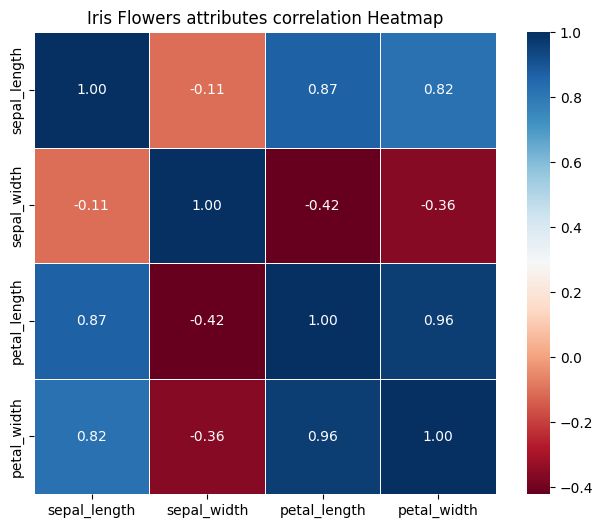

In [4]:
# Pairplot to visualize the relationships between features
correlation_matrix = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].corr()
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'RdBu', fmt = '.2f', linewidths = .5, square = True)
plt.title("Iris Flowers attributes correlation Heatmap")
plt.show()

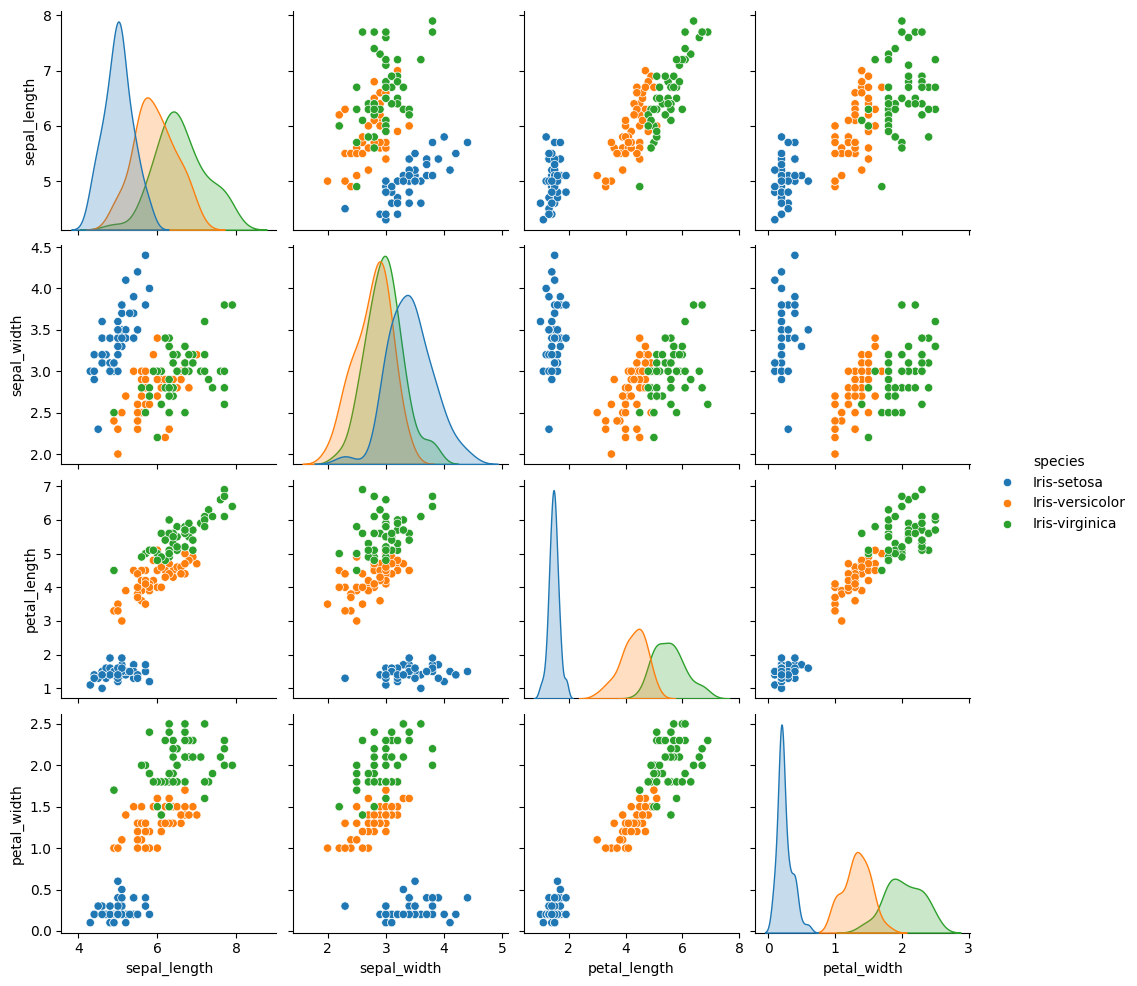

In [5]:
# Creating the pairplot
sns.pairplot(iris_df, hue = 'species')
plt.show()

# Step 4. Preparing the training and test sets
- Luckily, the dataset is rather good and have no need to preprocess on the imputing side of things.
- Here we will separate the features and target label.
- Then we will split the dataset into training and test sets.
- We will also normalize the data using a standard scaler due to the difference in features' range (i.e Setosa having a way larger range).
* The point of using the StandardScaler function here is to set the mean of each numerical column to zero, and the standard deviation to 1. This is to ensure that if between different columns/features they have a huge difference in range magnitude (i.e a column has numerical data in the range from 1-100, and another one with the range in just 1-10; then the first column/feature would dominate the model), then the data after being normalized would be better for the machine learning model to train on. As it is not the numbers that matter but how they compare to other observations within that column/feature.
- A hypothetical example would be if sepal length are closer to 5, and there is a trend among Iris-setosa species to have that attribute, while Iris-virginica sepal length are closer to 1, then the model would classify the unknown flower closer to being Iris-setosa. This demonstrates that it is not the magnitude that matters but how the value fits within data observations.



In [6]:
# Getting the features to predict which species the flower belongs to
X = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
# Getting the species/target label
y = iris_df['species']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standardize the features by removing the mean, and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5. Training and Testing Using 2 models
- In this project, we will use 2 models to train the dataset on. One being the Support Vector Machine (SVM) model; and the other being the k-Nearest Neighbours (k-NN) model.
- Both of these models are used to Classify objects based on the features in the dataset. So this project would be on the Classification side of machine learning problems, as opposed to being a Regression problem.
- The math behind these 2 models I also do not understand for now.

In [7]:
# Support Vector Machine training and prediction accuracy (SVM)
svm_classifier = SVC(kernel = 'linear', C = 1.0, random_state = 42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# k-Nearest Neighbours (k-NN)
knn_classifier = KNeighborsClassifier(n_neighbors = 3)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Printing the accuracies of the models
print(f"SVM accuracy: {accuracy_svm * 100:.2f}%")
print(f"k-NN accuracy: {accuracy_knn * 100:.2f}%")

SVM accuracy: 96.67%
k-NN accuracy: 100.00%


# Step 6. Final Visualization on Model accuracy
- And finally, we will make a chart to display the accuracy of our models. Then we will create a confusion matrix. (Do note that the Iris dataset is not the best example for the use of a confusion matrix - Refer to the titanic dataset for a better example of this use).
---
- The main reason why we would need a confusion matrix is to fully display the number of correct and incorrect predictions for each class, revealing the error that the model is making. Not in this case, but in a binary classifier, the confusion matrix would show us the True Positives (TP-correctly predicted positives), True Negatives (TN-correctly predicted negatives), False Positives (FP-false alarms), False Negatives (FN-missed cases).
- The explanation for the 2 false cases are:
- False Positives means that the model predicted the presence of something when it is not actually there - raising a false alarm. Ex: A medical model predicting that a patient has a disease but it is not true.
-  False Negatives means the opposite, it fails to detect the presence of something when in fact it is actually there - being a missed case. Ex: A medical model not predicting that a patient actually has a disease.



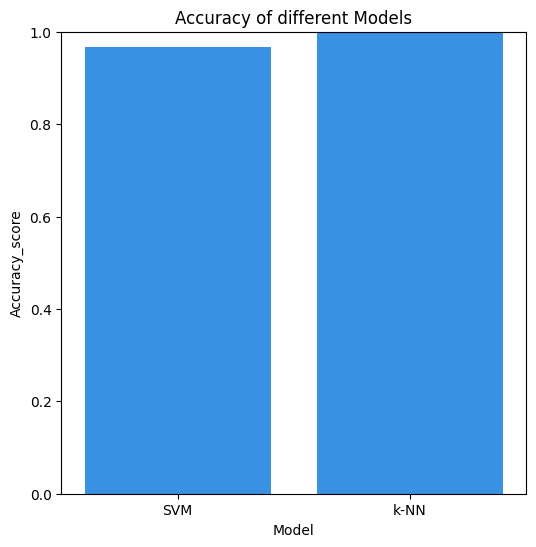

In [8]:
# Making a barchart to see the difference between our model's accuracy
results_df = pd.DataFrame({
    "Model": ["SVM", "k-NN"],
    "Accuracy_score": [accuracy_svm, accuracy_knn]
})

# Plotting the bar graph
plt.figure(figsize = (6, 6))
sns.barplot(x = "Model", y = "Accuracy_score", data = results_df, color = "dodgerblue")
plt.title("Accuracy of different Models")
plt.ylim(0, 1) # Set the y-axis limit to the range of 0 to 1 (accuracy range)
plt.show()

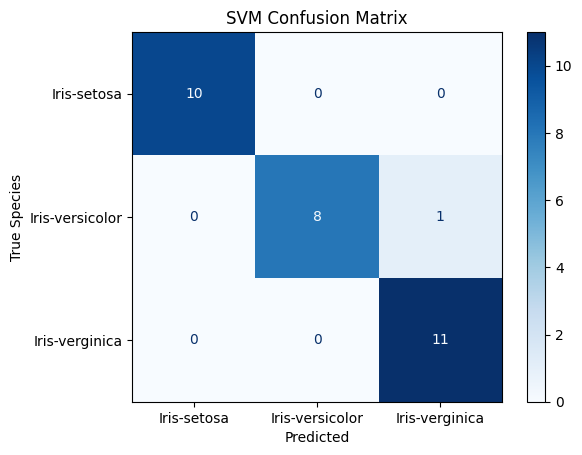

In [9]:
"""
Making a confusion matrix to evaluate the performance of our classification models
"""
# The confusion matrix for our SVM model
svm_cm = confusion_matrix(y_test, y_pred_svm)

# Making the colourmap
svm_cm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ["Iris-setosa", "Iris-versicolor", "Iris-verginica"])
svm_cm_disp.plot(cmap = plt.cm.Blues) # You can change the colour here
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Species")
plt.show()

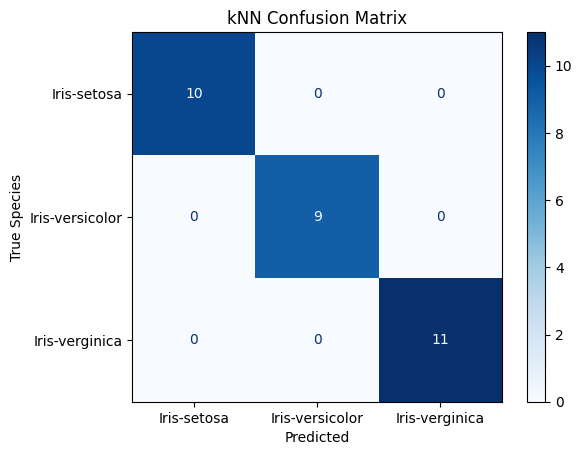

In [10]:
# The confusion matrix for our k-NN model
kNN_cm = confusion_matrix(y_test, y_pred_knn)

# Making the colourmap
kNN_cm_disp = ConfusionMatrixDisplay(confusion_matrix = kNN_cm, display_labels = ["Iris-setosa", "Iris-versicolor", "Iris-verginica"])
kNN_cm_disp.plot(cmap = plt.cm.Blues) # You can change the colour here
plt.title("kNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Species")
plt.show()